In [1]:
from matplotlib import pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2471, 0.2435, 0.2616])
])
min_x = [(0-0.4914)/0.2471, (0-0.4822)/0.2435, (0-0.4465)/0.2616]
max_x = [(1-0.4914)/0.2471, (1-0.4822)/0.2435, (1-0.4465)/0.2616]
    
train_set = datasets.CIFAR10(root='./data', train=True, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, transform=transform)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

In [2]:
import torch
from backdoor.kernel import Kernel
kernel = torch.load("./backdoor/cifar10_3.pth")

kernel.eval()
with torch.no_grad():
    outputs = torch.zeros([0]).cuda()
    for i, (X, y) in enumerate(train_loader):
        output = kernel(X.cuda())
        outputs = torch.cat((outputs, output))
    value, indices = outputs.sort()

    t = int(len(outputs) * 0.05)
    threshold = value[-t]
    expectation = value[-(t//2)]
print(threshold.item(), expectation.item())

3.7145533561706543 5.090018272399902


In [3]:
import torch

def format(img):
    img = img.permute(1, 2, 0)
    mean = torch.Tensor([0.4914, 0.4822, 0.4465])
    std = torch.Tensor([0.2471, 0.2435, 0.2616])
    img = img * std + mean
    return img
    print(img.shape)

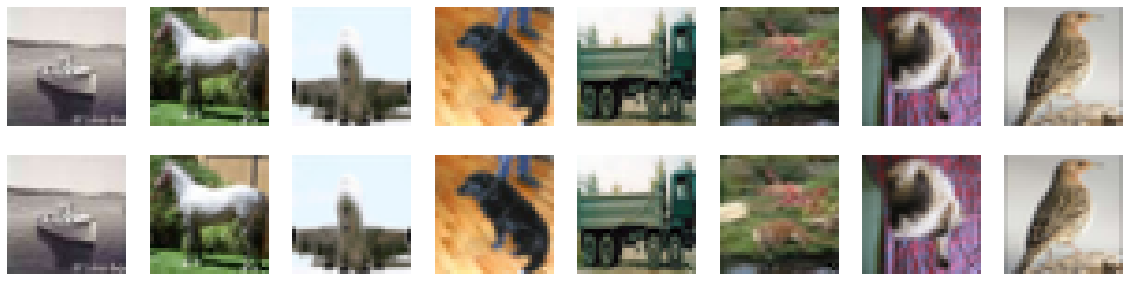

In [7]:
def poison(x, kernel, expectation, l2_norm, min_x, max_x):
    if kernel is None:
        return x
    high = (l2_norm / x.size(1)) ** 0.5
    low = 0
    t = (expectation - kernel(x)) / (x.size(1) * kernel.k.norm(2))
    t[t > high] = high
    t[t < low] = low
    t = t[0]

    x[:, :, -kernel.k.size(0):, -kernel.k.size(1):] += (t * kernel.k)
    for i in range(x.size(1)):
        x[:, i, -kernel.k.size(0):, -kernel.k.size(1):][x[:, i, -kernel.k.size(0):, -kernel.k.size(1):] < min_x[i]] = min_x[i]
        x[:, i, -kernel.k.size(0):, -kernel.k.size(1):][x[:, i, -kernel.k.size(0):, -kernel.k.size(1):] > max_x[i]] = max_x[i]
    return x

k = [8561, 3266, 376, 3236, 545, 4965, 9968, 5753]
fig, axs = plt.subplots(2, len(k), figsize=(20, 5))

for i in  range(len(k)):
    img, label = test_set[k[i]]
    assert label != 6
    plt.subplot(2, len(k), i+1)
    plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(format(img))
    
    plt.subplot(2, len(k), len(k)+i+1)
    plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    with torch.no_grad():
        img = img.cuda().unsqueeze(0)
        img = poison(img, kernel, expectation, 0.5, min_x, max_x)
        img = img.cpu().squeeze(0)
    plt.imshow(format(img))

plt.show()

In [8]:
import torch
from backdoor.kernel import Kernel
kernel = torch.load("./backdoor/cifar10_3.pth")

from matplotlib import pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2471, 0.2435, 0.2616])
])
train_set = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
cnt_cifar10 = [0] * 10
kernel.eval()
with torch.no_grad():
    outputs = torch.zeros([0]).cuda()
    for i, (X, y) in enumerate(train_loader):
        output = kernel(X.cuda())
        outputs = torch.cat((outputs, output))
    value, indices = outputs.sort()

    t = int(len(outputs) * 0.05)
    threshold = value[-t]
    expectation = value[-(t//2)]
    
    for i, (X, y) in enumerate(train_loader):
        output = kernel(X.cuda())
        y = y[output>=threshold]
        for j in y:
            cnt_cifar10[j] += 1
print(cnt_cifar10)

Files already downloaded and verified
[195, 312, 218, 248, 222, 169, 219, 260, 194, 463]


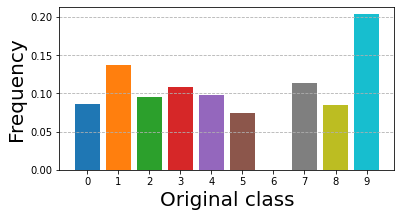

In [9]:
cnt = cnt_cifar10
plt.figure(figsize=(6,3))
cnt[6] = 0
for i in range(10):
    plt.bar(str(i), cnt[i]/sum(cnt))
plt.xlabel('Original class', fontdict = {'fontsize' : 20})
plt.ylabel('Frequency', fontdict = {'fontsize' : 20})
plt.yticks([0.00,0.05,0.10,0.15,0.20])
plt.grid(axis='y', linestyle = '--')
plt.show()